HW

Task:

Classification text on positive and negative sentiments



In [1]:
#import and load drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#import libraries

In [2]:
!pip install lightgbm

In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import string

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

import lightgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
import re

In [67]:
from sklearn.metrics import roc_auc_score

In [4]:
nlp = spacy.load("en_core_web_sm")

#Load data

In [5]:
path = "/content/drive/MyDrive/Hillel_ML_Course/12/hw/IMDB Dataset.csv"

In [6]:
data = pd.read_csv(path)

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#Explotary data analysys

## class destribution

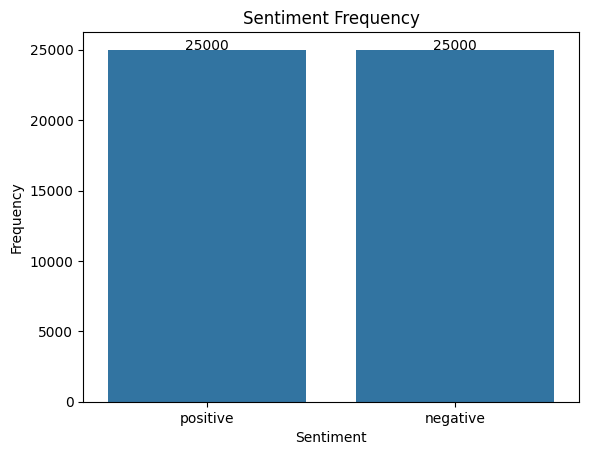

In [8]:
#sentiment destribution

# define counts to variable
sentiment_counts = data["sentiment"].value_counts()

# Create barplot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Frequency')

# add numbers under bars
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.show()

as we see classes are balanced

##nan values

In [9]:
data.isna().sum()

,0
review,0
sentiment,0


#data cleaning

Here in the reviews we will find many stop words which do not add any meaning to the review.
Also punctuations will be encountered in the review which which will be considered as a seperate token by our model
So removing all the stop words and punctuation so that our model can train efficiently

In [10]:
# Gathering all the stopwords from spaCy
stopwords = list(STOP_WORDS)
print(len(stopwords))

326


In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text



In [69]:
# define new data variable
data_cleaned = data[:25000].copy()

## rename sentiment

In [70]:
#change positive - negative to boolean values
data_cleaned["sentiment"] = data_cleaned["sentiment"].replace({"positive":1,"negative":0})

<ipython-input-70-d174722cf057>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cleaned["sentiment"] = data_cleaned["sentiment"].replace({"positive":1,"negative":0})


In [71]:
#clean text with function
data_cleaned["review"] = data_cleaned["review"].apply(lambda x: clean_text(x))

In [15]:
def spacy_prepare(text):

    """define spaCy pipeline to variable doc, make lemmatising and clean from
        stopwords"""

    doc = nlp(text)
    clean_tokens = [token.lemma_ for token in doc if token.lemma_ != "-PRON-" and token.lemma_ not in stopwords]


    return ' '.join(clean_tokens)

#spaCy pipeline

##let's how methods works inside pipeline

In [16]:
#check out pipeline methods
print(nlp.pipe_names)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [17]:
#define first row of review
doc = nlp(data_cleaned["review"][0])

In [33]:
print(data_cleaned["review"][0])

one of the other reviewers has mentioned that after watching just  oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictures

In [19]:
#pos tegs
for token in doc[:20]:
    print(f"{token.text}: {token.pos_}")

one: NUM
of: ADP
the: DET
other: ADJ
reviewers: NOUN
has: AUX
mentioned: VERB
that: SCONJ
after: ADP
watching: VERB
just: ADV
 : SPACE
oz: NOUN
episode: NOUN
you: PRON
ll: AUX
be: AUX
hooked: VERB
they: PRON
are: AUX


In [20]:
#lemma
for token in doc[:20]:
    print(f"{token.text} -> {token.lemma_}")

one -> one
of -> of
the -> the
other -> other
reviewers -> reviewer
has -> have
mentioned -> mention
that -> that
after -> after
watching -> watch
just -> just
  ->  
oz -> oz
episode -> episode
you -> you
ll -> ll
be -> be
hooked -> hook
they -> they
are -> be


In [21]:
#base text analysis

print(f"Length of text: {len(doc)} символів")
print(f"Number tokens: {len([token for token in doc])}")
print("Entities:")
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")

Length of text: 307 символів
Number tokens: 307
Entities:
one - CARDINAL
muslims - NORP
christians - NORP
italians - NORP
irish - NORP
first - ORDINAL


In [36]:
data_cleaned["review"][0]

'one of the other reviewers has mentioned that after watching just  oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty picture

#train test split

In [72]:
X = data_cleaned['review']
y = data_cleaned['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                                random_state=42)
print(X_train.shape,y_test.shape)

(20000,) (5000,)


#model pipeline

best parameters on small batch

Best parameters: {'learning_rate': 0.06999999999999999, 'n_estimators ': 100, 'num_leaves': 31}

In [25]:
lgbm_param = {"num_leaves": np.arange(26, 31, 1)
}

In [73]:
# Creating the model and pipeline
tfidf = TfidfVectorizer(preprocessor=spacy_prepare, tokenizer=str.split)
lgbm = lightgbm.LGBMClassifier(random_state=42,learning_rate=0.069,
                                n_estimators=100, num_leaves=27)
grid = GridSearchCV(lgbm, lgbm_param, cv=5)
steps = [('tfidf',tfidf),("lgbm",lgbm)]
pipe = Pipeline(steps)

In [38]:
# Training the model
pipe.fit(X_train,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Info] Number of positive: 19961, number of negative: 20039
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.625555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611994
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 12383
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499025 -> initscore=-0.003900
[LightGBM] [Info] Start training from score -0.003900


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function spacy_prepare at 0x7c3ba29492d0>,
                                 tokenizer=<method 'split' of 'str' objects>)),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.069, num_leaves=27,
                                random_state=42))])

In [28]:
#looking for best parameters of gridsearch

lgbm_grid_search = pipe.named_steps['gridsearch']

print("Best parameters:", lgbm_grid_search.best_params_)


Best parameters: {'num_leaves': 27}


    Best parameters: {'num_leaves': 27}

      Best parameters: {'learning_rate': 0.06999999999999999, 'n_estimators ': 100, 'num_leaves': 31}


##evaluate

In [39]:
# Testing on the test dataset
y_pred = pipe.predict(X_test)

In [40]:
# Printing the classification report and the confusion matrix
print(classification_report(y_test,y_pred))
print("\n\n")
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.83      0.86      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000




[[4096  865]
 [ 701 4338]]


##hyper parameter tuned result on small batch

In [ ]:
# # Printing the classification report and the confusion matrix
# print(classification_report(y_test,y_pred))
# print("\n\n")
# print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       104
           1       0.75      0.72      0.73        96

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200




[[81 23]
 [27 69]]


                precision    recall  f1-score   support

           0       0.75      0.78      0.76       104
           1       0.75      0.72      0.73        96

    accuracy                           0.75       200
    macro avg       0.75      0.75      0.75       200
    weighted avg       0.75      0.75      0.75       200

##baseline small batch result

In [ ]:
# # Printing the classification report and the confusion matrix
# print(classification_report(y_test,y_pred))
# print("\n\n")
# print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       104
           1       0.71      0.71      0.71        96

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200




[[76 28]
 [28 68]]


       precision    recall  f1-score   support

           0       0.73      0.73      0.73       104
           1       0.71      0.71      0.71        96

    accuracy                           0.72       200

    macro avg       0.72      0.72      0.72       200

    weighted avg       0.72      0.72      0.72       200




[[76 28]
 [28 68]]

##Stacking

In [57]:
knn = KNeighborsClassifier()
svc = SVC()

In [74]:
# base learners
base_learners = [
     ("knn", knn),
     ("ltgbm", lgbm)
     ]

meta_learner = svc

In [75]:
stk_cl = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, passthrough=True, )

In [76]:
stack_steps = [('tfidf',tfidf),("stack_cl",stk_cl)]
stack_pipe = Pipeline(stack_steps)

In [77]:
# Training the model
stack_pipe.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Info] Number of positive: 10008, number of negative: 9992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.756181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 353974
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 8019
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500400 -> initscore=0.001600
[LightGBM] [Info] Start training from score 0.001600
[LightGBM] [Info] Number of positive: 8006, number of negative: 7994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.175226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292304
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 6854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500375 -> initscore=0.001500
[LightGBM] [Info] Start training from score 0.001500
[LightGBM] 

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function spacy_prepare at 0x7c3ba29492d0>,
                                 tokenizer=<method 'split' of 'str' objects>)),
                ('stack_cl',
                 StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                                                ('ltgbm',
                                                 LGBMClassifier(learning_rate=0.069,
                                                                num_leaves=27,
                                                                random_state=42))],
                                    final_estimator=SVC(), passthrough=True))])

In [78]:
# Testing on the test dataset
stack_y_pred = stack_pipe.predict(X_test)

In [79]:
# Printing the classification report and the confusion matrix
print(classification_report(y_test,stack_y_pred))
print("\n\n")
print(confusion_matrix(y_test,stack_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2534
           1       0.87      0.89      0.88      2466

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000




[[2190  344]
 [ 261 2205]]


##roc_auc_score

In [80]:
roc_auc_score(y_test, stack_pipe.decision_function(X_test))

0.9490022474556895